In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import seaborn as sns

Using TensorFlow backend.


In [2]:
def load_data(): 
    train = pd.read_json('data/train.json')
    train['inc_angle'] = train['inc_angle'].fillna(0)
    
    test = pd.read_json('data/test.json')
    test['inc_angle'] = test['inc_angle'].fillna(0)
    
    return(train, test)

In [3]:
(train, test) = load_data()
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.0589694977, -26.0589694977, -26.058969497...","[-25.7542076111, -25.7542076111, -25.754207611...",4023181e,32.615072
2,"[-14.1410999298, -15.0642414093, -17.375520706...","[-14.745639801, -14.5904102325, -14.3626976013...",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.3745937347, -26.0271816254, -28.121963501...","[-25.7223434448, -27.0115776062, -23.149162292...",4371c8c3,43.918874


In [4]:
x_train_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_train_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

x_test_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_test_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])

X_train = np.concatenate([ x_train_band1[:, :, :, np.newaxis],  
                           x_train_band2[:, :, :, np.newaxis] ],
                         axis=-1)

X_angle_train = np.array(train.inc_angle)


Y_train = np.array(train["is_iceberg"])


X_test = np.concatenate([ x_test_band1[:, :, :, np.newaxis],  
                          x_test_band2[:, :, :, np.newaxis] ],
                        axis=-1)

X_angle_test = np.array(test.inc_angle)

id_test = test.id

print('Freeing some memory')
train = []
test = []

Freeing some memory


In [5]:
def normalize(dataset):
    shape = dataset.shape
    flattened  = dataset.flatten()
    normalized = (flattened - flattened.mean()) / (flattened.max() - flattened.min())
    print(normalized.shape)
    
    return normalized.reshape(shape)

X_train = normalize(X_train)
X_test = normalize(X_test)

(18045000,)
(94770000,)


In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_train.shape[1:])
X_train.max()

(1604, 75, 75, 2)
(8424, 75, 75, 2)
(75, 75, 2)


0.72370511

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate RMSprop optimizer
# opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [8]:
batch_size = 100
epochs = 50
patience = 2
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=patience)

# cw = {0 : 1., 1: 2.9} # 1:2.9 is best so far! 
# print(cw)

history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True, 
                    callbacks=[early_stopping], 
                    validation_split=0.1)

Train on 1443 samples, validate on 161 samples
Epoch 1/50
1443/1443 [==============================] - 34s - loss: 0.6196 - acc: 0.6369 - val_loss: 0.6907 - val_acc: 0.4348

In [9]:
predictions = model.predict(X_test)

In [10]:
pred = pd.DataFrame(predictions, columns=['is_iceberg'])
id_test = pd.DataFrame(id_test)
out_pred = pd.concat([id_test, pred], axis=1)

# out_pred = out_pred.fillna(0) # hack
out_pred.head(10)

,id,is_iceberg
0,5941774d,0.066862
1,4023181e,0.924022
2,b20200e4,0.225311
3,e7f018bb,0.990299
4,4371c8c3,0.492680
5,a8d9b1fd,0.973270
6,29e7727e,0.056531
7,92a51ffb,0.996351
8,c769ac97,0.140181
9,aee0547d,0.165038


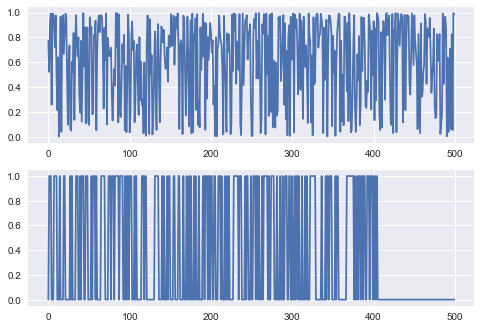

In [13]:
plt.subplot(2,1,1)
plt.plot(predictions[-500:])

plt.subplot(2,1,2)
plt.plot(Y_train[-500:])

# pd.DataFrame(Y_train).hist()
plt.show()

In [12]:
out_pred.to_csv('./output/predictions.csv', index=False)